In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [191]:
df = pd.read_csv('/content/drive/MyDrive/UU/ETH-USD (BaoCao).csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,136.836243,138.995270,136.434784,136.443619,136.443619,3756124824
1,2019-03-02,136.350082,137.184799,132.436386,134.206955,134.206955,3747176425
2,2019-03-03,134.786118,135.849289,131.328857,132.249420,132.249420,3454374053
3,2019-03-04,132.157883,132.729141,125.402702,127.774124,127.774124,4008171341
4,2019-03-05,127.792953,138.229980,126.735298,137.822388,137.822388,4764849990


In [192]:

df['Date'] = pd.to_datetime(df['Date'])

df.set_index('Date', inplace=True)

In [193]:
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

In [194]:

# Chuẩn hóa dữ liệu
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close).reshape(-1, 1))

In [195]:
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1920 entries, 2019-03-01 to 2024-06-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1920 non-null   float64
 1   High       1920 non-null   float64
 2   Low        1920 non-null   float64
 3   Close      1920 non-null   float64
 4   Adj Close  1920 non-null   float64
 5   Volume     1920 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 105.0 KB


In [196]:


cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']  # Correct the column name 'Adj Close'
df = df[cols]
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-03-01,136.836243,138.995270,136.434784,136.443619,136.443619,3756124824
2019-03-02,136.350082,137.184799,132.436386,134.206955,134.206955,3747176425
2019-03-03,134.786118,135.849289,131.328857,132.249420,132.249420,3454374053
2019-03-04,132.157883,132.729141,125.402702,127.774124,127.774124,4008171341
2019-03-05,127.792953,138.229980,126.735298,137.822388,137.822388,4764849990


In [197]:




from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def calculate_vif(df):
    """Calculate Variance Inflation Factor (VIF) for each variable."""
    vif_df = pd.DataFrame()
    vif_df["variables"] = df.columns
    vif_df["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_df

def cointegration_test(df, alpha=0.05, max_vif=10):
    """Perform Johanson's Cointegration Test and Report Summary"""
    # Convert numeric columns to float
    df_numeric = df.select_dtypes(include=['number']).astype(float)

    # Drop any columns with all zero values
    df_numeric = df_numeric.loc[:, (df_numeric != 0).any(axis=0)]

    # Drop constant columns to handle perfect multicollinearity
    df_numeric = df_numeric.loc[:, (df_numeric != df_numeric.iloc[0]).any()]

    # Calculate VIF and drop columns with VIF higher than the threshold
    while True:
        vif_df = calculate_vif(df_numeric)
        max_vif_value = vif_df['VIF'].max()
        if max_vif_value > max_vif:
            remove_col = vif_df.sort_values('VIF', ascending=False)['variables'].iloc[0]
            print(f"Removing {remove_col} with VIF {max_vif_value}")
            df_numeric = df_numeric.drop(columns=[remove_col])
        else:
            break

    out = coint_johansen(df_numeric, -1, 5)
    d = {'0.90': 0, '0.95': 1, '0.99': 2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]

    def adjust(val, length=6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df_numeric.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace, 2), 9), ">", adjust(cvt, 8), ' =>  ', trace > cvt)

# Example usage with your dataframe df
cointegration_test(df)

Removing Close with VIF inf
Removing High with VIF 4687.121442316028
Removing Low with VIF 1967.2441891579692
Removing Open with VIF 548.7024682751013
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Adj Close ::  14.65     > 12.3212   =>   True
Volume ::  0.0       > 4.1296    =>   False


In [198]:


df = df.sort_values(by='Date', ascending=True)

In [247]:

# Train, test
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

time_series = df[cols]
train_data = time_series[:int(0.7*len(time_series))]
test_data = time_series[int(0.7*len(time_series)):]

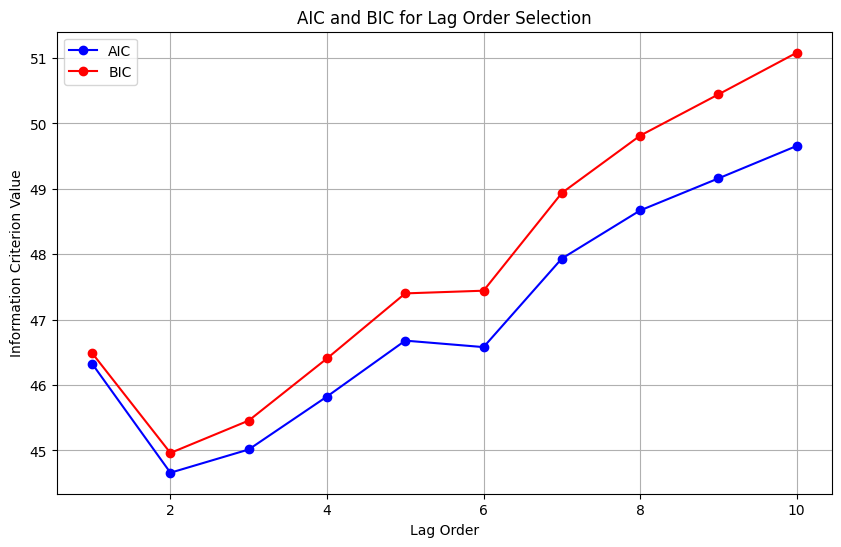

Optimal lag order based on AIC: 2
Optimal lag order based on BIC: 2


In [248]:


from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import aic, bic
import numpy as np

# Tạo danh sách các giá trị lag order cần kiểm tra
maxlags = 10  # Số lượng lag order tối đa để kiểm tra

# Khởi tạo list để lưu trữ các giá trị AIC và BIC
aic_values = []
bic_values = []

for lag in range(1, maxlags+1):
    model = VAR(train_data)
    try:
        results = model.fit(lag)
        aic_values.append(results.aic)
        bic_values.append(results.bic)
    except np.linalg.LinAlgError:
        print(f"Error fitting model with lag {lag}. Skipping.")
        continue  # Skip to the next lag if an error occurs

# Vẽ đồ thị AIC và BIC (only if any models were successfully fit)
if aic_values:  # Check if aic_values is not empty
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(range(1, len(aic_values) + 1), aic_values, marker='o', linestyle='-', color='b', label='AIC')
    plt.plot(range(1, len(bic_values) + 1), bic_values, marker='o', linestyle='-', color='r', label='BIC')
    plt.xlabel('Lag Order')
    plt.ylabel('Information Criterion Value')
    plt.title('AIC and BIC for Lag Order Selection')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Tìm lag order tối ưu dựa trên AIC hoặc BIC
    optimal_lag_aic = np.argmin(aic_values) + 1  # +1 vì index bắt đầu từ 0
    optimal_lag_bic = np.argmin(bic_values) + 1  # +1 vì index bắt đầu từ 0

    print(f'Optimal lag order based on AIC: {optimal_lag_aic}')
    print(f'Optimal lag order based on BIC: {optimal_lag_bic}')
else:
    print("No models could be fit successfully. Check for multicollinearity or singularity issues in your data.")

In [249]:

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [250]:
# ADF Test on each column
df_diff = df.diff().dropna()  # Calculate first differences and drop missing values

for name, column in df_diff.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.8376
 No. Lags Chosen       = 16
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.3895
 No. Lags Chosen       = 26
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Low" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.0

In [251]:
import warnings
warnings.filterwarnings("ignore")

In [252]:

df_diff = train_data.diff().dropna()
df_diff

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-03-02,-0.486161,-1.810471,-3.998398,-2.236664,-2.236664,-8.948399e+06
2019-03-03,-1.563964,-1.335510,-1.107529,-1.957535,-1.957535,-2.928024e+08
2019-03-04,-2.628235,-3.120148,-5.926155,-4.475296,-4.475296,5.537973e+08
2019-03-05,-4.364930,5.500839,1.332596,10.048264,10.048264,7.566786e+08
2019-03-06,10.165787,1.738846,9.410622,0.966964,0.966964,-1.757958e+08
...,...,...,...,...,...,...
2022-10-30,64.423218,-15.344360,29.501586,-28.915161,-28.915161,-7.688081e+09
2022-10-31,-29.216553,-6.584961,-23.566284,-18.068847,-18.068847,5.376846e+09
2022-11-01,-17.835937,-23.847168,12.179566,6.990112,6.990112,-4.799609e+09


In [253]:

# ADF Test on each column
for name, column in df_diff.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.0962
 No. Lags Chosen       = 18
 Critical value 1%     = -3.435
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.3319
 No. Lags Chosen       = 22
 Critical value 1%     = -3.435
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Low" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05

In [254]:


model = VAR(df_diff)

In [255]:




import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Assuming df_diff is your differenced DataFrame

# ADF Test on each column
for name, column in df_diff.items():
    result = adfuller(column) # Remove the 'name' argument
    print(f'ADF Statistic for {name}: {result[0]}') # Use f-string to print the name
    print(f'p-value: {result[1]}')
    print('\n')

# Check for multicollinearity
correlation_matrix = df_diff.corr()
print(correlation_matrix)

ADF Statistic for Open: -9.096199467835504
p-value: 3.709321686128675e-15


ADF Statistic for High: -7.331876501203263
p-value: 1.1223131714663983e-10


ADF Statistic for Low: -14.71830887520909
p-value: 2.777438365273053e-27


ADF Statistic for Close: -9.122553569531338
p-value: 3.1763374237965106e-15


ADF Statistic for Adj Close: -9.122553569531338
p-value: 3.1763374237965106e-15


ADF Statistic for Volume: -8.483501517829358
p-value: 1.3728895687860775e-13


               Open      High       Low     Close  Adj Close    Volume
Open       1.000000  0.594476  0.361089 -0.077390  -0.077390  0.102729
High       0.594476  1.000000  0.453908  0.478954   0.478954  0.215988
Low        0.361089  0.453908  1.000000  0.619988   0.619988 -0.426354
Close     -0.077390  0.478954  0.619988  1.000000   1.000000 -0.181374
Adj Close -0.077390  0.478954  0.619988  1.000000   1.000000 -0.181374
Volume     0.102729  0.215988 -0.426354 -0.181374  -0.181374  1.000000


In [256]:
fitted_model = model.fit() # Fit the VAR model and store it

lag_order = fitted_model.k_ar
print(lag_order)

1


In [257]:

predictions = fitted_model.forecast(df_diff.values[-lag_order:], steps=len(test_data))
predictions

array([[ 1.27125004e+01,  1.42147841e+01, -1.79332230e+01,
        -1.50885965e+01, -1.50885965e+01,  1.39278413e+09],
       [-1.52953882e+01, -1.27112578e+01,  1.15741004e+00,
         3.59652578e+00,  3.59652578e+00, -9.64421482e+07],
       [ 3.75303316e+00,  4.98190651e+00,  8.74946201e-02,
         1.10445023e+00,  1.10445023e+00, -1.30286489e+08],
       ...,
       [ 1.03155837e+00,  1.06063519e+00,  1.01762573e+00,
         1.03085686e+00,  1.03085686e+00,  8.74234803e+06],
       [ 1.03155837e+00,  1.06063519e+00,  1.01762573e+00,
         1.03085686e+00,  1.03085686e+00,  8.74234803e+06],
       [ 1.03155837e+00,  1.06063519e+00,  1.01762573e+00,
         1.03085686e+00,  1.03085686e+00,  8.74234803e+06]])

In [258]:





# Calculate the starting index based on the length of the predictions array
start_index = len(df) - len(predictions)

df_forecast = pd.DataFrame(predictions, index=df.index[start_index:], columns=[col + '_1d' for col in df.columns])
df_forecast

,Open_1d,High_1d,Low_1d,Close_1d,Adj Close_1d,Volume_1d
Date,,,,,,
2022-11-04,12.712500,14.214784,-17.933223,-15.088597,-15.088597,1.392784e+09
2022-11-05,-15.295388,-12.711258,1.157410,3.596526,3.596526,-9.644215e+07
2022-11-06,3.753033,4.981907,0.087495,1.104450,1.104450,-1.302865e+08
2022-11-07,1.084725,-0.155377,1.526043,0.582717,0.582717,9.111391e+07
2022-11-08,0.574609,1.418982,0.754502,1.300458,1.300458,-2.806690e+07
...,...,...,...,...,...,...
2024-05-28,1.031558,1.060635,1.017626,1.030857,1.030857,8.742348e+06
2024-05-29,1.031558,1.060635,1.017626,1.030857,1.030857,8.742348e+06
2024-05-30,1.031558,1.060635,1.017626,1.030857,1.030857,8.742348e+06


In [259]:



def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns  # Get the actual column names from df_train
    for col in columns:
        # Use the correct column names from df_train when creating forecasted columns
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = invert_transformation(train_data, df_forecast)
# Now, define fc_cols based on the actual forecasted column names
fc_cols = [col + '_forecast' for col in train_data.columns]
df_results = df_results[fc_cols]
df_results

,Open_forecast,High_forecast,Low_forecast,Close_forecast,Adj Close_forecast,Volume_forecast
Date,,,,,,
2022-11-04,1532.437354,1570.974428,1499.168462,1516.453151,1516.453151,1.564114e+10
2022-11-05,1517.141966,1558.263170,1500.325872,1520.049677,1520.049677,1.554469e+10
2022-11-06,1520.894999,1563.245077,1500.413367,1521.154127,1521.154127,1.541441e+10
2022-11-07,1521.979725,1563.089700,1501.939410,1521.736844,1521.736844,1.550552e+10
2022-11-08,1522.554333,1564.508682,1502.693912,1523.037302,1523.037302,1.547745e+10
...,...,...,...,...,...,...
2024-05-28,2107.634136,2165.791502,2079.756294,2107.442914,2107.442914,2.044508e+10
2024-05-29,2108.665694,2166.852137,2080.773920,2108.473771,2108.473771,2.045383e+10
2024-05-30,2109.697252,2167.912773,2081.791546,2109.504628,2109.504628,2.046257e+10


In [260]:

# Forecasting 30 days ahead (adjust the 'steps' parameter as needed)
predictions_future = fitted_model.forecast(test_data.diff().values[-10:], steps=30)

last_date = df.index[-1]
start_date = last_date + pd.Timedelta(days=1)

# Create the index for the forecasted days
forecast_index = pd.date_range(start=start_date, periods=30, freq='D')

# Create a DataFrame for the forecasted values
df_forecast_30days = pd.DataFrame(predictions_future, index=forecast_index, columns=df.columns + '_1d')

print(df_forecast_30days.head())

              Open_1d    High_1d     Low_1d  Close_1d  Adj Close_1d  \
2024-06-02  51.390955  43.804043  31.305393 -8.291586     -8.291586   
2024-06-03  -7.622008 -11.086702 -14.750314  0.030448      0.030448   
2024-06-04  -0.540346   3.829619   9.697961  3.455645      3.455645   
2024-06-05   3.844322   0.944587  -3.706494 -0.494723     -0.494723   
2024-06-06  -0.734154   0.826265   3.790125  1.818874      1.818874   

               Volume_1d  
2024-06-02  8.182841e+08  
2024-06-03  4.877484e+08  
2024-06-04 -3.374006e+08  
2024-06-05  1.748049e+08  
2024-06-06 -6.272204e+07  


In [261]:


def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Create forecasted columns using '_forecast' suffix
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results_30days = invert_transformation(test_data, df_forecast_30days)

# Define fc_cols based on the actual forecasted column names in df_results_30days
fc_cols = [col for col in df_results_30days.columns if '_forecast' in col]
df_results_30days = df_results_30days[fc_cols]
df_results_30days.head()

,Open_forecast,High_forecast,Low_forecast,Close_forecast,Adj Close_forecast,Volume_forecast
2024-06-02,3811.275232,3873.098721,3781.145481,3804.907389,3804.907389,9.479309e+09
2024-06-03,3803.653224,3862.012018,3766.395167,3804.937837,3804.937837,9.967057e+09
2024-06-04,3803.112878,3865.841637,3776.093128,3808.393482,3808.393482,9.629656e+09
2024-06-05,3806.957199,3866.786225,3772.386635,3807.898759,3807.898759,9.804461e+09
2024-06-06,3806.223045,3867.612489,3776.176759,3809.717633,3809.717633,9.741739e+09


In [262]:
df_results_30days = invert_transformation(test_data, df_forecast_30days)
df_results_30days = df_results_30days[fc_cols]
df_results_30days

,Open_forecast,High_forecast,Low_forecast,Close_forecast,Adj Close_forecast,Volume_forecast
2024-06-02,3811.275232,3873.098721,3781.145481,3804.907389,3804.907389,9.479309e+09
2024-06-03,3803.653224,3862.012018,3766.395167,3804.937837,3804.937837,9.967057e+09
2024-06-04,3803.112878,3865.841637,3776.093128,3808.393482,3808.393482,9.629656e+09
2024-06-05,3806.957199,3866.786225,3772.386635,3807.898759,3807.898759,9.804461e+09
2024-06-06,3806.223045,3867.612489,3776.176759,3809.717633,3809.717633,9.741739e+09
2024-06-07,3808.181823,3868.868684,3775.538973,3810.358999,3810.358999,9.782342e+09
2024-06-08,3808.745211,3869.799993,3777.538926,3811.586037,3811.586037,9.775920e+09
2024-06-09,3810.016962,3870.944381,3777.982775,3812.515553,3812.515553,9.792208e+09
2024-06-10,3810.922675,3871.951396,3779.330651,3813.599513,3813.599513,9.797147e+09
2024-06-11,3812.020927,3873.045615,3780.160401,3814.602451,3814.602451,9.807799e+09


In [263]:

# Forecasting 60 days ahead (adjust the 'steps' parameter as needed)
predictions_future = fitted_model.forecast(test_data.diff().values[-10:], steps=60)

last_date = df.index[-1]
start_date = last_date + pd.Timedelta(days=1)

# Create the index for the forecasted days
forecast_index = pd.date_range(start=start_date, periods=60, freq='D')

# Create a DataFrame for the forecasted values
df_forecast_60days = pd.DataFrame(predictions_future, index=forecast_index, columns=df.columns + '_1d')

print(df_forecast_60days.head())

              Open_1d    High_1d     Low_1d  Close_1d  Adj Close_1d  \
2024-06-02  51.390955  43.804043  31.305393 -8.291586     -8.291586   
2024-06-03  -7.622008 -11.086702 -14.750314  0.030448      0.030448   
2024-06-04  -0.540346   3.829619   9.697961  3.455645      3.455645   
2024-06-05   3.844322   0.944587  -3.706494 -0.494723     -0.494723   
2024-06-06  -0.734154   0.826265   3.790125  1.818874      1.818874   

               Volume_1d  
2024-06-02  8.182841e+08  
2024-06-03  4.877484e+08  
2024-06-04 -3.374006e+08  
2024-06-05  1.748049e+08  
2024-06-06 -6.272204e+07  


In [264]:

df_results_60days = invert_transformation(test_data, df_forecast_60days)
df_results_60days = df_results_60days[fc_cols]
df_results_60days

,Open_forecast,High_forecast,Low_forecast,Close_forecast,Adj Close_forecast,Volume_forecast
2024-06-02,3811.275232,3873.098721,3781.145481,3804.907389,3804.907389,9.479309e+09
2024-06-03,3803.653224,3862.012018,3766.395167,3804.937837,3804.937837,9.967057e+09
2024-06-04,3803.112878,3865.841637,3776.093128,3808.393482,3808.393482,9.629656e+09
2024-06-05,3806.957199,3866.786225,3772.386635,3807.898759,3807.898759,9.804461e+09
2024-06-06,3806.223045,3867.612489,3776.176759,3809.717633,3809.717633,9.741739e+09
2024-06-07,3808.181823,3868.868684,3775.538973,3810.358999,3810.358999,9.782342e+09
2024-06-08,3808.745211,3869.799993,3777.538926,3811.586037,3811.586037,9.775920e+09
2024-06-09,3810.016962,3870.944381,3777.982775,3812.515553,3812.515553,9.792208e+09
2024-06-10,3810.922675,3871.951396,3779.330651,3813.599513,3813.599513,9.797147e+09
2024-06-11,3812.020927,3873.045615,3780.160401,3814.602451,3814.602451,9.807799e+09


In [265]:

# Forecasting 90 days ahead (adjust the 'steps' parameter as needed)
predictions_future = fitted_model.forecast(test_data.diff().values[-10:], steps=90)

last_date = df.index[-1]
start_date = last_date + pd.Timedelta(days=1)

# Create the index for the forecasted days
forecast_index = pd.date_range(start=start_date, periods=90, freq='D')

# Create a DataFrame for the forecasted values
df_forecast_90days = pd.DataFrame(predictions_future, index=forecast_index, columns=df.columns + '_1d')

print(df_forecast_90days.head())

              Open_1d    High_1d     Low_1d  Close_1d  Adj Close_1d  \
2024-06-02  51.390955  43.804043  31.305393 -8.291586     -8.291586   
2024-06-03  -7.622008 -11.086702 -14.750314  0.030448      0.030448   
2024-06-04  -0.540346   3.829619   9.697961  3.455645      3.455645   
2024-06-05   3.844322   0.944587  -3.706494 -0.494723     -0.494723   
2024-06-06  -0.734154   0.826265   3.790125  1.818874      1.818874   

               Volume_1d  
2024-06-02  8.182841e+08  
2024-06-03  4.877484e+08  
2024-06-04 -3.374006e+08  
2024-06-05  1.748049e+08  
2024-06-06 -6.272204e+07  


In [266]:

df_results_90days = invert_transformation(test_data, df_forecast_90days)
df_results_90days = df_results_90days[fc_cols]
df_results_90days

,Open_forecast,High_forecast,Low_forecast,Close_forecast,Adj Close_forecast,Volume_forecast
2024-06-02,3811.275232,3873.098721,3781.145481,3804.907389,3804.907389,9.479309e+09
2024-06-03,3803.653224,3862.012018,3766.395167,3804.937837,3804.937837,9.967057e+09
2024-06-04,3803.112878,3865.841637,3776.093128,3808.393482,3808.393482,9.629656e+09
2024-06-05,3806.957199,3866.786225,3772.386635,3807.898759,3807.898759,9.804461e+09
2024-06-06,3806.223045,3867.612489,3776.176759,3809.717633,3809.717633,9.741739e+09
...,...,...,...,...,...,...
2024-08-26,3890.396219,3953.641085,3857.567811,3892.957187,3892.957187,1.047158e+10
2024-08-27,3891.427777,3954.701720,3858.585437,3893.988044,3893.988044,1.048032e+10
2024-08-28,3892.459336,3955.762355,3859.603063,3895.018901,3895.018901,1.048907e+10
2024-08-29,3893.490894,3956.822990,3860.620689,3896.049758,3896.049758,1.049781e+10


In [267]:
predict_data_index_60 = pd.RangeIndex(start=len(df)+29, stop=len(df)+59, step=1)
predict_data_index_90 = pd.RangeIndex(start=len(df)+59, stop=len(df)+89, step=1)

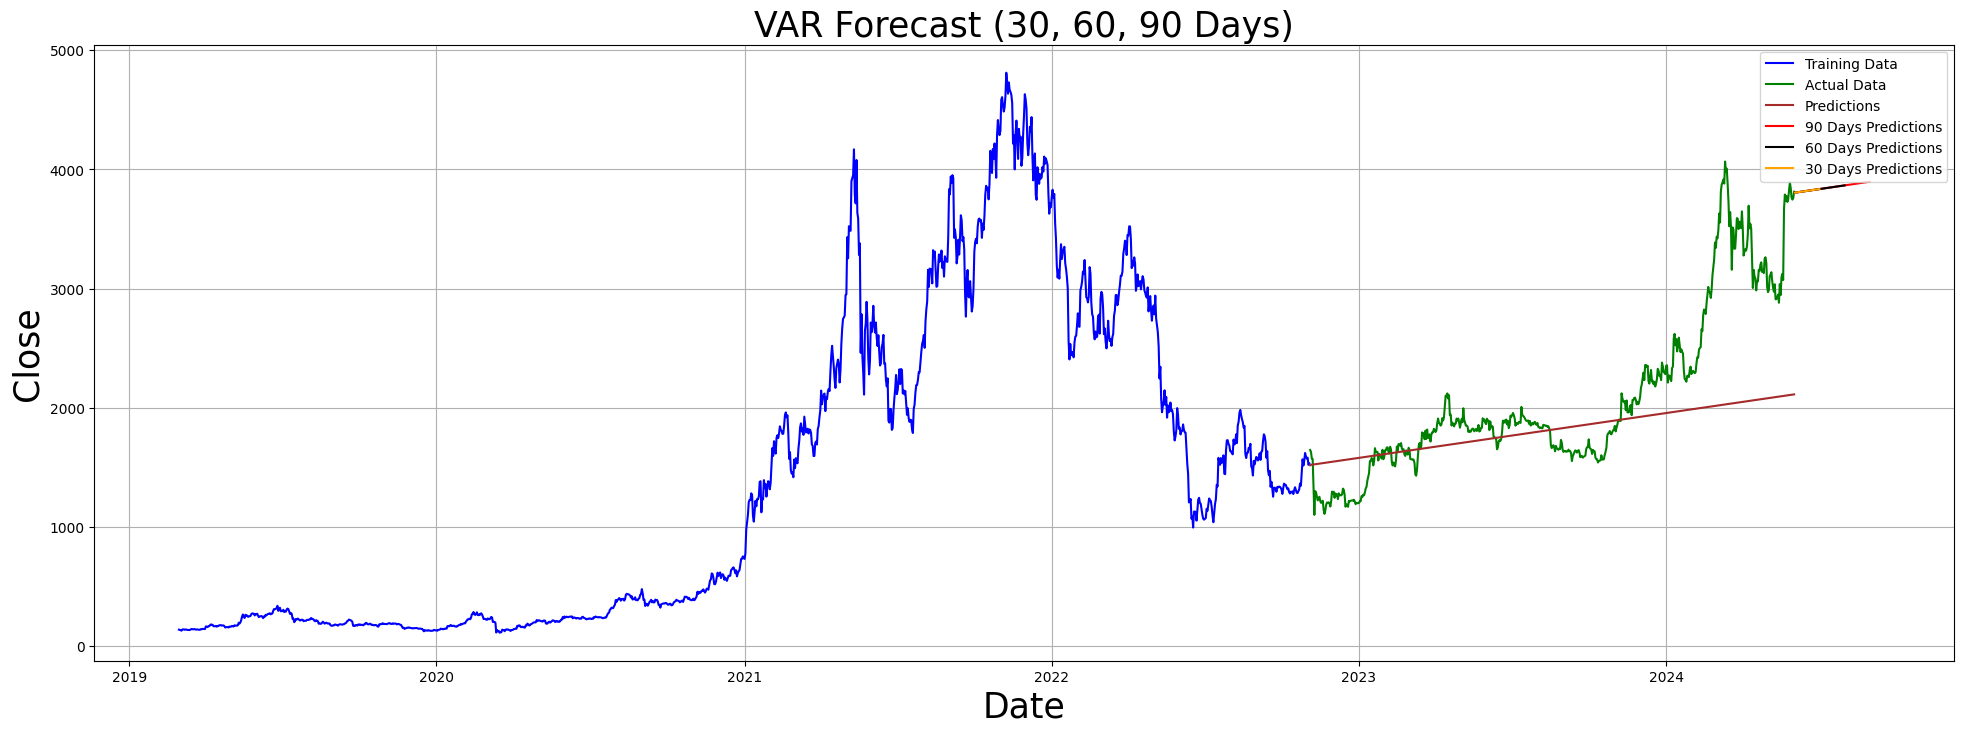

In [268]:


import matplotlib.pyplot as plt

# Assuming df_results_30days, df_results_60days, df_results_90days are your DataFrames containing forecast results
# Define the date range for plotting
start_date = '2019-01-03'
end_date = '2024-08-30'

# Plotting the data
plt.figure(figsize=(24, 8))

# Plotting the training data
plt.plot(train_data.index, train_data.Close, label='Training Data', color='blue')

# Plotting the actual test data
plt.plot(test_data.index, test_data.Close, label='Actual Data', color='green')
# Plotting the prediction data
plt.plot(test_data.index, df_results.Close_forecast, label='Predictions', color ='brown')
# Plotting the forecast results

plt.plot(df_results_90days.index, df_results_90days.Close_forecast, label='90 Days Predictions', color='red')

plt.plot(df_results_60days.index, df_results_60days.Close_forecast, label='60 Days Predictions', color='black')
plt.plot(df_results_30days.index, df_results_30days.Close_forecast, label='30 Days Predictions', color='orange')
# Adding title and labels
plt.title('VAR Forecast (30, 60, 90 Days)', fontsize=25)
plt.xlabel('Date', fontsize=25)
plt.ylabel('Close', fontsize=25)

# Adding legend and grid
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


In [269]:

y_test = test_data.Close
y_pred = df_results.Close_forecast

In [270]:

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np



test_91_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_91_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
test_91_mse = np.mean((np.array(y_test) - np.array(y_pred))**2)
print('Testing RMSE:', test_91_rmse)
print('Testing MAPE:', test_91_mape)
print('Testing MSE:', test_91_mse)

Testing RMSE: 616.3934037417995
Testing MAPE: 16.32411545563276
Testing MSE: 379940.828176401
